In [1]:
import matplotlib.pyplot as plt
import logging
import os

import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.optim import Adam

In [2]:
SAVED_PARAMS_PATH = os.path.join('.', 'saved_params_without_noise')
if not os.path.exists(SAVED_PARAMS_PATH):
    os.mkdir(SAVED_PARAMS_PATH)
    # logging config
log_file_path = os.path.join('./', 'mnist_with_dropout_and_noise__without_noise.log')
logging.basicConfig(filename=log_file_path, encoding='utf-8', level=logging.DEBUG, force=True)

# Task 1 - Main Functions

## Dataset operations

In [3]:
def custom_dataloader(batch_size, num_class=10, noise=False):
    # transformers
    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,))
    ])

    # MNIST dataset train/test
    train_dataset = MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = MNIST('./data', train=False, download=True, transform=transform)

    # sampling 1000 data from each class for simplicity
    train_labels = train_dataset.targets
    counter_dict = torch.zeros(10)
    sampled_indices = []
    for idx, label in enumerate(train_labels):
        if counter_dict[label] < 1000:
            sampled_indices.append(idx)
            counter_dict[label] = counter_dict[label] + 1
        if torch.sum(counter_dict).item() == 10000:
            break

    train_subset = Subset(train_dataset, torch.tensor(sampled_indices))

    # loaders
    train_loader = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

    train_data, train_label = next(iter(train_loader))
    test_data, test_label = next(iter(test_loader))

    if noise:
        # adding noise to train samples
        num_of_noisy_samples = (train_data.size(0) * 4) // 10
        selected_idx = torch.randperm(train_data.size(0))[:num_of_noisy_samples]

        for selected_id in selected_idx:
            # find noisy class
            curr_class = train_label[selected_id]
            noise = torch.randint(num_class, size=(1,))[0]
            while curr_class != noise:
                noise = torch.randint(num_class, size=(1,))[0]

            train_label[selected_id] = noise
        logging.info('noise is added to the dataset')

    train_data, train_label = torch.split(train_data, batch_size), torch.split(train_label, batch_size)
    test_data, test_label = torch.split(test_data, batch_size), torch.split(test_label, batch_size)

    train_loader = list(zip(train_data, train_label))
    test_loader = list(zip(test_data, test_label))

    logging.info('dataset is handled')

    return train_loader, test_loader

## Create model class

In [4]:
class CustomModel(nn.Module):
    def __init__(self, param_size_param, dropout_param, input_dimension=784, num_class=10):
        super().__init__()
        self._param_size_param = param_size_param
        self._dropout_param = dropout_param
        self._input_dimension = input_dimension
        self._num_class = num_class

        self.__hidden_layer = nn.Linear(self._input_dimension, self._param_size_param)
        self.__out_layer = nn.Linear(self._param_size_param, self._num_class)
        self.__relu = nn.ReLU()
        if dropout_param != 1:
            self.__dropout = nn.Dropout(self._dropout_param)
        else:
            self.__dropout = None

    def forward(self, input_data):
        out = input_data.reshape(input_data.size(0), -1)
        out = self.__hidden_layer(out)
        out = self.__relu(out)
        if self.__dropout:
            out = self.__dropout(out)
        out = self.__out_layer(out)
        return out


## Train and test functions

In [5]:
def main_epoch(model, optimizer, criterion, device, train_loader, test_loader, epoch):
    running_loss, running_training_acc = [], []
    tot_loss = 0
    for idx, (data, label) in enumerate(train_loader):
        model.train()
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()

        preds = model(data)
        loss = criterion(preds, label)
        loss.backward()
        optimizer.step()

        tot_loss += loss.item()
        running_loss.append(loss.item())

        if idx == 0 or (idx + 1) % 10 == 0:
            model.eval()
            tot_acc = 0
            tot_data = 0
            with torch.no_grad():
                for train_data, train_label in train_loader:
                    train_data, train_label = train_data.to(device), train_label.to(device)
                    train_preds = model(train_data)
                    train_pred_idx = torch.argmax(train_preds, dim=1)
                    tot_acc += torch.count_nonzero((train_pred_idx == train_label).long())
                    tot_data += train_data.shape[0]
                running_training_acc.append(tot_acc.item() / tot_data)
            if idx == 0:
                print('loss: {}, train acc: {}'.format(loss, running_training_acc[-1]))
                logging.info('loss: {}, train acc: {}'.format(loss, running_training_acc[-1]))
            else:
                print('loss: {}, train acc: {}'.format(tot_loss / 10, running_training_acc[-1]))
                logging.info('loss: {}, train acc: {}'.format(tot_loss / 10, running_training_acc[-1]))
                tot_loss = 0

    model.eval()
    tot_acc = 0
    tot_data = 0
    with torch.no_grad():
        for idx, (test_data, test_label) in enumerate(test_loader):
            test_data, test_label = test_data.to(device), test_label.to(device)
            test_preds = model(test_data)
            test_pred_idx = torch.argmax(test_preds, dim=1)
            tot_acc += torch.count_nonzero((test_pred_idx == test_label).long())
            tot_data += test_data.shape[0]
        accuracy = tot_acc.item() / tot_data
    print('epoch: {}, loss: {}, train acc: {}, test acc: {}'.format(epoch, running_loss[-1], running_training_acc[-1], accuracy))
    logging.info('epoch: {}, loss: {}, train acc: {}, test acc: {}'.format(epoch, running_loss[-1], running_training_acc[-1], accuracy))
    return running_loss, running_training_acc, accuracy

def main_param_dropout(batch_size, param_size_param, dropout_param, number_of_epochs=80, lr=0.001, noise=False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = CustomModel(param_size_param, dropout_param).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    if noise:
        train_loader, test_loader = custom_dataloader(batch_size, noise=noise)
    else:
        train_loader, test_loader = custom_dataloader(batch_size, noise=noise)

    running_loss, running_training_acc, running_accuracy = [], [], []

    print('#####training and testing start with K:{}, P:{}######'.format(param_size_param, dropout_param))
    logging.info('#####training and testing start with K:{}, P:{}######'.format(param_size_param, dropout_param))
    for epoch in range(number_of_epochs):
        curr_running_loss, curr_running_training_acc, curr_accuracy = main_epoch(model, optimizer, criterion, device, train_loader, test_loader, epoch)
        running_loss += curr_running_loss
        running_training_acc += curr_running_training_acc
        running_accuracy.append(curr_accuracy)
    print('#####training and testing end with K:{}, P:{}######'.format(param_size_param, dropout_param))
    logging.info('#####training and testing end with K:{}, P:{}######'.format(param_size_param, dropout_param))
    return running_loss, running_training_acc, running_accuracy

def param_dropout_grid(batch_size, param_size_param_arr, dropout_param_arr, **kwargs):
    for param_size_idx, param_size_param in enumerate(param_size_param_arr):
        for dropout_idx, dropout_param in enumerate(dropout_param_arr):
            running_loss, running_training_acc, running_accuracy = main_param_dropout(batch_size, param_size_param, dropout_param, **kwargs)
            save_param_path = os.path.join(SAVED_PARAMS_PATH, 'exp_k_{}_p_{}.pth'.format(param_size_idx, dropout_idx))
            torch.save({
                'running_loss': running_loss,
                'running_training_acc': running_training_acc, 
                'running_accuracy': running_accuracy
            },save_param_path)

## Plotting functions

In [37]:
def get_train_test_best_accuracies(path, size):
    exp_name_arr = os.listdir(path)
    train_acc_matrix = torch.empty(size)
    acc_matrix = torch.empty(size)
    for exp_name in exp_name_arr:
        split_exp_name = exp_name.split('.')[0].split('_')
        k_idx, p_idx = int(split_exp_name[-3]), int(split_exp_name[-1])
        exp_path = os.path.join(path, exp_name)
        checkpoint = torch.load(exp_path)
        train_acc, acc = checkpoint['running_training_acc'], checkpoint['running_accuracy']
        best_train_acc = max(train_acc)
        best_acc = max(acc)
        train_acc_matrix[k_idx, p_idx] = best_train_acc
        acc_matrix[k_idx, p_idx] = best_acc
    return train_acc_matrix, acc_matrix

def plot_k_set_p_1_train_test(train_best_accuracy, test_best_accuracy, param_size_param_arr, noise=False):
    train_acc = train_best_accuracy[:, -1]
    acc = test_best_accuracy[:, -1]

    plt.figure(figsize=(10, 5))
    plt.plot(list(range(len(train_acc))), train_acc, label='train')
    plt.scatter(list(range(len(train_acc))), train_acc)
    plt.plot(list(range(len(acc))), acc, label='test')
    plt.scatter(list(range(len(acc))), acc)
    plt.xlabel('$\mathcal{K}$ parameter')
    plt.ylabel('accuracy')
    plt.title('accuracy vs. $\mathcal{K}$ parameter - no dropout regularization')
    plt.legend(loc='lower right')
    plt.xticks(list(range(len(param_size_param_arr))), [str(x) for x in param_size_param_arr])

    if noise:
        plt_save_path = os.path.join('.', 'plots_with_noise')
        if not os.path.exists(plt_save_path):
            os.mkdir(plt_save_path)
    else:
        plt_save_path = os.path.join('.', 'plots_without_noise')
        if not os.path.exists(plt_save_path):
            os.mkdir(plt_save_path)
    plt_path = os.path.join(plt_save_path, 'k_set_p_1_train_test.jpeg')
    plt.savefig(plt_path, dpi=300)
    plt.show()

def plot_k_p_train(train_best_accuracy, param_size_param_arr, dropout_param_arr, noise=False):
    plt.figure(figsize=(10, 5))

    for idx, dropout_param in enumerate(dropout_param_arr):
        plt.plot(list(range(len(train_best_accuracy[:, idx]))), train_best_accuracy[:, idx], label='$\mathcal{P}$: ' + '{}'.format(dropout_param))
        plt.scatter(list(range(len(train_best_accuracy[:, idx]))), train_best_accuracy[:, idx])
    plt.xlabel('$\mathcal{K}$ parameter')
    plt.ylabel('train accuracy')
    plt.title('training accuracy vs. $\mathcal{K}$ parameter with different dropout parameters')
    plt.legend(loc='lower right')
    plt.xticks(list(range(len(param_size_param_arr))), [str(x) for x in param_size_param_arr])

    if noise:
        plt_save_path = os.path.join('.', 'plots_with_noise')
        if not os.path.exists(plt_save_path):
            os.mkdir(plt_save_path)
    else:
        plt_save_path = os.path.join('.', 'plots_without_noise')
        if not os.path.exists(plt_save_path):
            os.mkdir(plt_save_path)
    plt_path = os.path.join(plt_save_path, 'k_p_train.jpeg')
    plt.savefig(plt_path, dpi=300)
    plt.show()

def plot_k_p_test(test_best_accuracy, param_size_param_arr, dropout_param_arr, noise=False):
    plt.figure(figsize=(10, 5))

    for idx, dropout_param in enumerate(dropout_param_arr):
        plt.plot(list(range(len(test_best_accuracy[:, idx]))), test_best_accuracy[:, idx], label='$\mathcal{P}$: ' + '{}'.format(dropout_param))
        plt.scatter(list(range(len(test_best_accuracy[:, idx]))), test_best_accuracy[:, idx])
    plt.xlabel('$\mathcal{K}$ parameter')
    plt.ylabel('test accuracy')
    plt.title('test accuracy vs. $\mathcal{K}$ parameter with different dropout parameters')
    plt.legend(loc='lower right')
    plt.xticks(list(range(len(param_size_param_arr))), [str(x) for x in param_size_param_arr])

    if noise:
        plt_save_path = os.path.join('.', 'plots_with_noise')
        if not os.path.exists(plt_save_path):
            os.mkdir(plt_save_path)
    else:
        plt_save_path = os.path.join('.', 'plots_without_noise')
        if not os.path.exists(plt_save_path):
            os.mkdir(plt_save_path)
    plt_path = os.path.join(plt_save_path, 'k_p_test.jpeg')
    plt.savefig(plt_path, dpi=300)
    plt.show()

# Task 2 - Parameter Grid

In [ ]:
param_dropout_grid(128, [1, 5, 10, 20, 40], [0.1, 0.5, 1])

In [39]:
train_acc_matrix_wout_noise, acc_matrix_wout_noise = get_train_test_best_accuracies('./saved_params_without_noise', (5, 3))

## No dropout regularization and effect of $k$

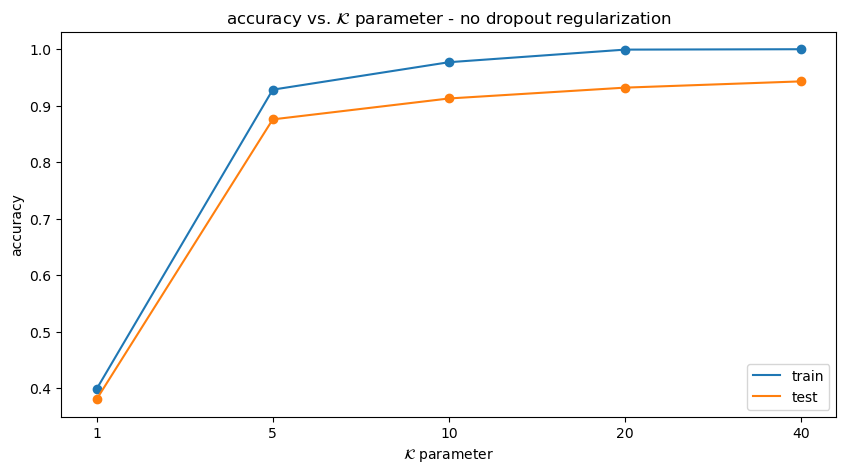

In [40]:
plot_k_set_p_1_train_test(train_acc_matrix_wout_noise, acc_matrix_wout_noise, [1, 5, 10, 20, 40])

As it can be seen from the graph, as $k$ increases the performance also increases, for both training and test accuracies. The training accuracy becomes, 100% when the parameter $k$ is set to 20 and 40.

## Training accuracy for each $k$ and $p$

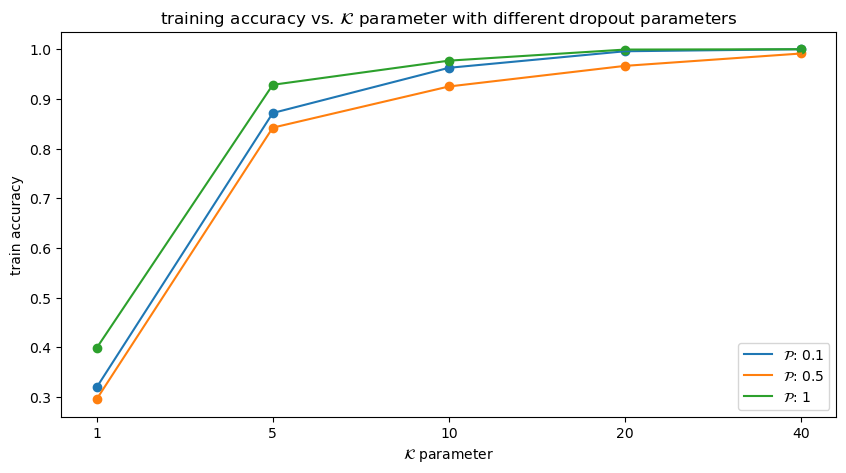

In [41]:
plot_k_p_train(train_acc_matrix_wout_noise, [1, 5, 10, 20, 40], [0.1, 0.5, 1])

Depending on the above graph, when the dropout parameter is small, the training accuracy can provide better results rather than when the parameter set to a larger value. When there is no regularization at all the model training accuracy reaches its best result for each k. When $\mathcal{P}$ is set to 1 then for $k$ equals to either 20 and 40 it reaches 100% accuracy. When $\mathcal{P}$ is set to 0.1 then for $k$ equals to either 20 and 40 it reaches 100% accuracy. When $\mathcal{P}$ is set to 0.5 then for $k$ equals to 40 it reaches approximately 100% accuracy.

## Test accuracy for each $k$ and $p$

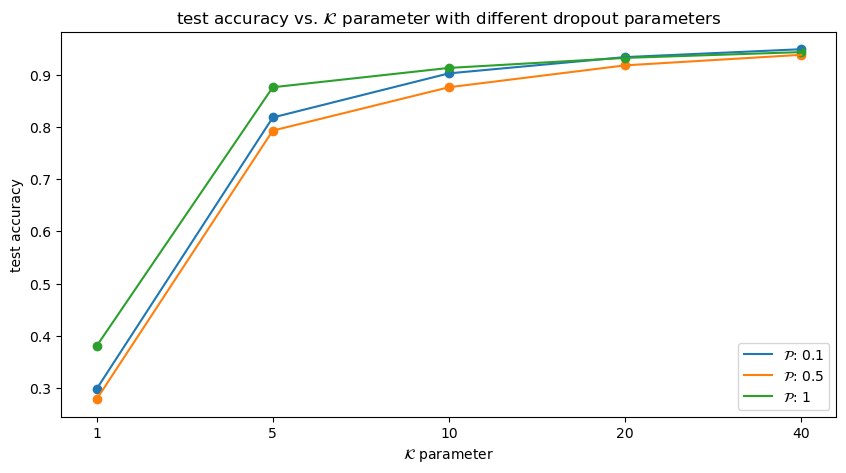

In [42]:
plot_k_p_test(acc_matrix_wout_noise, [1, 5, 10, 20, 40], [0.1, 0.5, 1])

For the test accuracy, it nearly watches the same path with training accuracy but fewer accuracy results. The effect of dropout parameter seems similar with training accuracy experiment also. The test accuracy reaches its best results when $k$=40 and $p$=1.

# Task 3 - Adding Noise to Labels

In [7]:
SAVED_PARAMS_PATH = os.path.join('.', 'saved_params_with_noise')
if not os.path.exists(SAVED_PARAMS_PATH):
    os.mkdir(SAVED_PARAMS_PATH)
    # logging config
log_file_path = os.path.join('./', 'mnist_with_dropout_and_noise__with_noise.log')
logging.basicConfig(filename=log_file_path, encoding='utf-8', level=logging.DEBUG, force=True)

In [ ]:
param_dropout_grid(128, [1, 5, 10, 20, 40], [0.1, 0.5, 1], noise=True)

In [43]:
train_acc_matrix_with_noise, acc_matrix_with_noise = get_train_test_best_accuracies('./saved_params_with_noise', (5, 3))

## No dropout regularization and effect of $k$

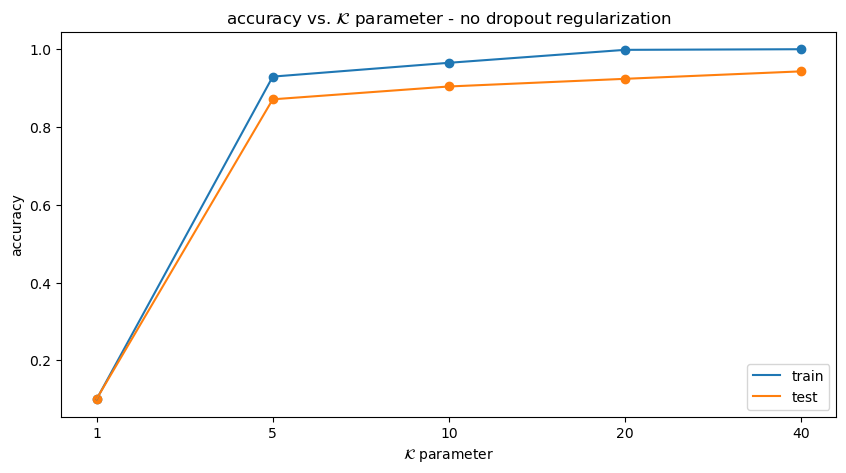

In [44]:
plot_k_set_p_1_train_test(train_acc_matrix_with_noise, acc_matrix_with_noise, [1, 5, 10, 20, 40], noise=True)

As it can be seen from the graph, as $k$ increases the performance also increases, for both training and test accuracies. The training accuracy becomes, 100% when the parameter $k$ is set to 20 and 40.

## Training accuracy for each $k$ and $p$

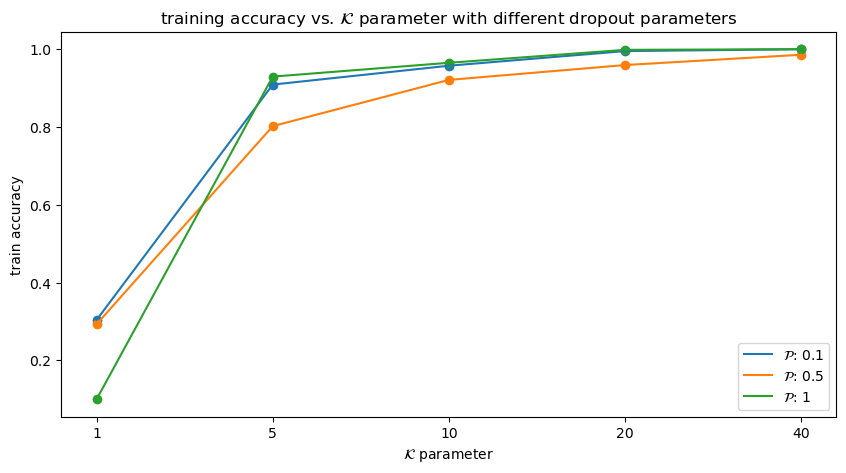

In [45]:
plot_k_p_train(train_acc_matrix_with_noise, [1, 5, 10, 20, 40], [0.1, 0.5, 1], noise=True)

Depending on the above graph, when the dropout parameter is small, the training accuracy can provide better results rather than when the parameter set to a larger value. This time because there is some perturbation on training data, the training accuracy results of $p$=0.1 is comparably close to $p$=1. Also, the gap between experiment $p$=0.5 and other experiments are reduced. When $\mathcal{P}$ is set to 1 then for $k$ equals to either 20 and 40 it reaches 100% accuracy. When $\mathcal{P}$ is set to 0.1 then for $k$ equals to either 20 and 40 it reaches 100% accuracy. When $\mathcal{P}$ is set to 0.5 then for $k$ equals to 40 it reaches approximately 100% accuracy again.

## Test accuracy for each $k$ and $p$

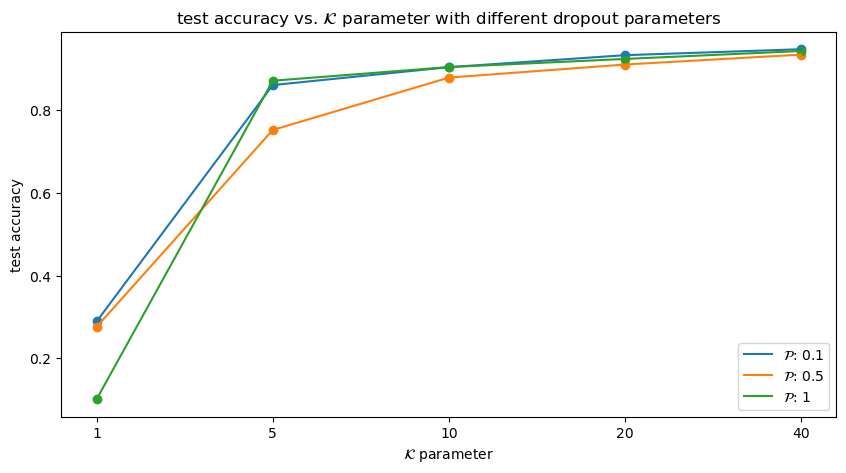

In [46]:
plot_k_p_test(acc_matrix_with_noise, [1, 5, 10, 20, 40], [0.1, 0.5, 1], noise=True)

For the test accuracy, it nearly watches the same path with training accuracy but fewer accuracy results. Also, because we have some noise on the data, we also have some accuracy drops. The effect of dropout parameter seems similar with training accuracy experiment also. The test accuracy reaches its best results when $k$=40 and $p$=0.1.

# Task 4 - Comments

By comparing the Task 2 and Task 3 it could be said that, the noise causes some test accuracy drops. In that case, the dropout parameter should be more promising than the experiment without noise. When we add the noise to some selected samples in the training data, we slightly change the distance between training and test dataset. That is, we increase the distance between test and training data. That is why using regularization techniques for generalization such as dropout should affect the inference process. Assuming that the MNIST dataset has very simple distribution, the change between experiment with and without noise is not very significant. However, the results support the intuition behind it.